In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# params for dataset loading
# IMPT: remember to change ds_order (dataset order) accordingly
store_path = './datasets/sa/'
dataset_paths = ['4g_1.csv', '4g_2.csv', '5G_TEST_1.csv', '5G_2.csv', 'bt_2.csv']
ds_order = ['4G', '4G', 'WIFI', 'WIFI', 'BLUETOOTH']
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in ds_order])))}

# do consistency checks
# stop execution if dataset_paths and ds_order are not of equal length
assert (len(dataset_paths) == len(ds_order)), 'Length of dataset_paths and ds_order are mismatched.'
# check if all ds_order tags are in record_tags
# assert all(item in list(record_tags.keys()) for item in ds_order), 'Not all ds_order tags exist in record_tags'

In [9]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for path in dataset_paths:
    path = store_path + path
    print(f'loading {path}...', end=' ')
    
    # load dataset details
    df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
    df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')
    
    specs.append(df_spec)

    # load data
    df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
    df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
    df['I'] = df['I'].astype('float')
    
    print(f'loaded')
    
    datasets.append(df)
    
print('done.')

loading ./datasets/sa/4g_1.csv... loaded
loading ./datasets/sa/4g_2.csv... loaded
loading ./datasets/sa/5G_TEST_1.csv... loaded
loading ./datasets/sa/5G_2.csv... loaded
loading ./datasets/sa/bt_2.csv... loaded
done.


In [10]:
np.unique(ds_order)

array(['4G', 'BLUETOOTH', 'WIFI'], dtype='<U9')

In [11]:
specs[4]

,info
SamplingFrequency,56000000
NumberSamples,1014
NumberRecords,23885


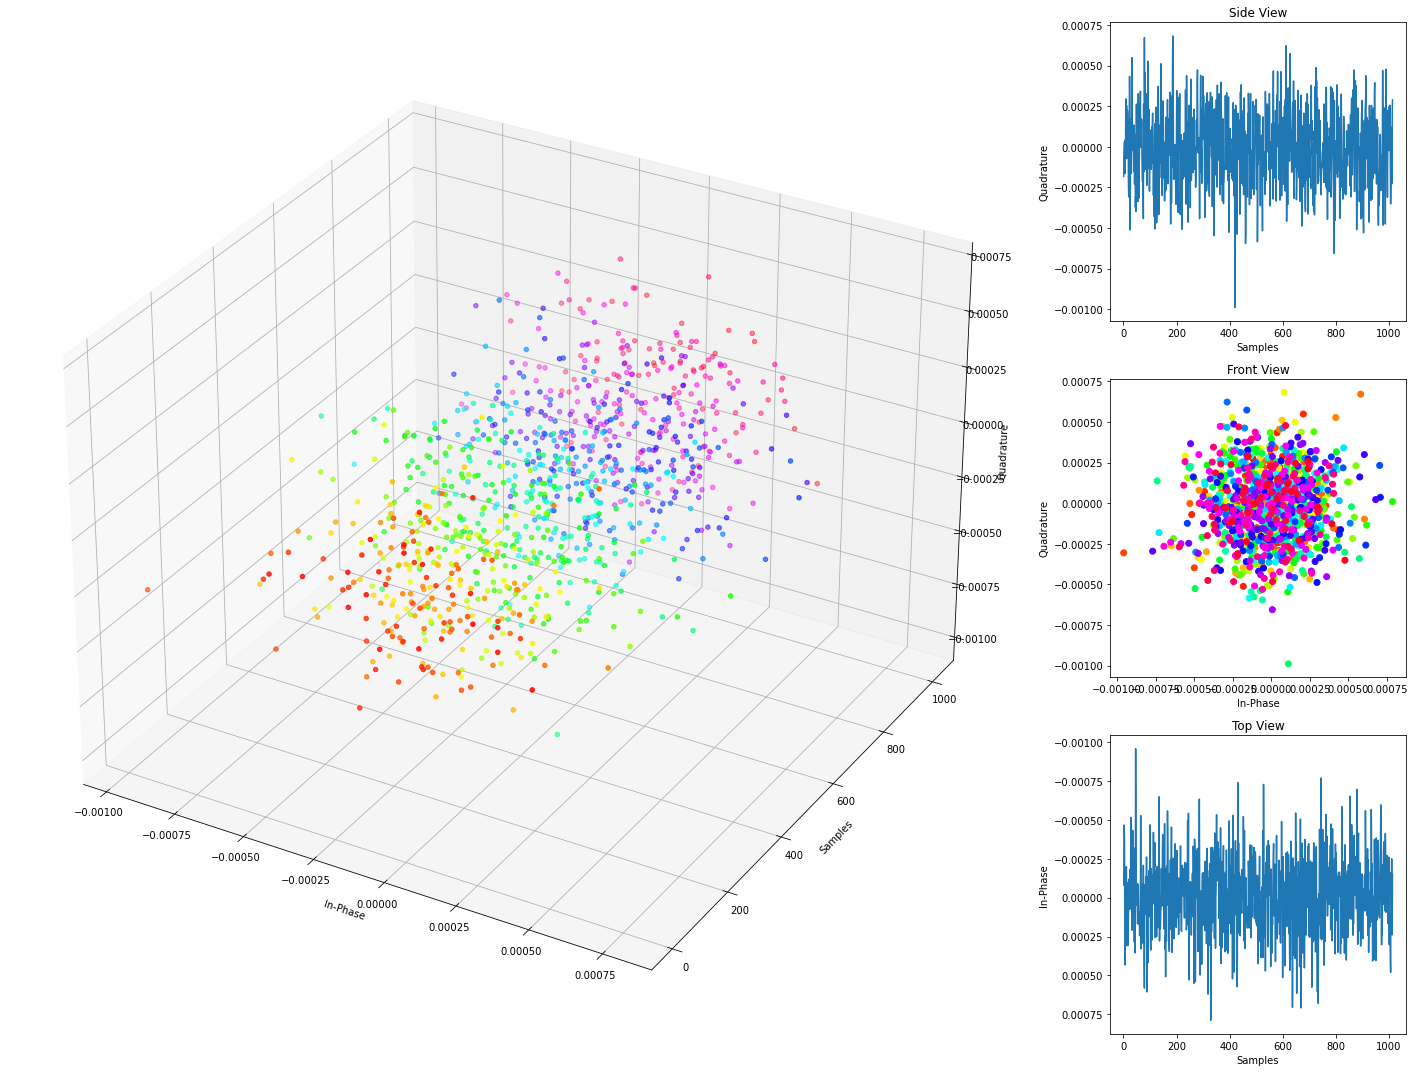

In [12]:
# plot a record sample
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:3, :3], projection='3d')

x = datasets[2].iloc[:specs[2].loc['NumberSamples']['info']]['I'].values
z = datasets[2].iloc[:specs[2].loc['NumberSamples']['info']]['Q'].values
y = np.arange(1, specs[2].loc['NumberSamples']['info']+1)

ax.scatter(x, y, z, c=y, cmap='hsv')
ax.set_xlabel('In-Phase')
ax.set_ylabel('Samples')
ax.set_zlabel('Quadrature')

ax1 = fig.add_subplot(gs[0, 3])
ax1.plot(y, z)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Quadrature')
ax1.set_title('Side View')

ax2 = fig.add_subplot(gs[1, 3])
ax2.scatter(x, z, c=y, cmap='hsv')
ax2.set_xlabel('In-Phase')
ax2.set_ylabel('Quadrature')
ax2.set_title('Front View')

ax3 = fig.add_subplot(gs[2, 3])
ax3.plot(y, x)
ax3.set_xlabel('Samples')
ax3.set_ylabel('In-Phase')
ax3.set_title('Top View')
ax3.invert_yaxis()


plt.tight_layout()
plt.show()

In [19]:
# split dataset(s) into records, extract test dataset
train = []

# number of test records to extract
ntest = 100

print(f'Type\t\tTotal Records\tSamples/Record')
for i in range(len(datasets)):
    nrecords = specs[i].loc['NumberRecords']['info']
    nsamples = specs[i].loc['NumberSamples']['info']
    ds_length = datasets[i].shape[0]

    # sanity check
    print(f'{ds_order[i]:<13}\t{nrecords:<7}\t\t{nsamples:<7}')

    # loop through dataset to split 
    for j in range(ds_length // 1024):
        # extract sample length worth of samples for each record, then transpose for easier access later
        record = datasets[i].iloc[(1024 * j):(1024 * (j+1))].values.T
    
        # add processed record to list
        train.append([ds_order[i], signal_tags[ds_order[i]], record])

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(train, columns=['signal_type', 'tag', 'record']).sample(frac=1, random_state=42)
df_test = df_train.groupby('signal_type', group_keys=False).apply(lambda df: df.head(ntest)).sample(frac=1, random_state=42)
df_train = df_train.drop(df_test.index)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')

Type		Total Records	Samples/Record
4G           	3202   		1014   
4G           	3550   		1014   
WIFI         	2699   		1014   
WIFI         	1200   		1014   
BLUETOOTH    	23885  		1014   

            Stats             
Dataset	Length	Records/Sample
Train	33896	1024
Test	300  	1024


In [16]:
df_train.head(3)

,signal_type,tag,record
19968,BLUETOOTH,1,"[[2.197e-05, 0.00010171, 0.00066824, 0.0001522..."
28283,BLUETOOTH,1,"[[0.00057062, -0.00039739, -0.0001015, 0.00094..."
12487,BLUETOOTH,1,"[[0.00081595, 8.97e-06, 0.0004215, 1.138e-05, ..."


In [52]:
# ensure no data gets corrupted in processing
I_check = sum(df_records['record'].iloc[0][0] == df.iloc[:df_spec.loc['NumberSamples']['info']]['I'].values) == df_spec.loc['NumberSamples']['info']
Q_check = sum(df_records['record'].iloc[0][1] == df.iloc[:df_spec.loc['NumberSamples']['info']]['Q'].values) == df_spec.loc['NumberSamples']['info']

print(f'I check: {I_check} | Q check: {Q_check}')

I check: True | Q check: True
